In [1]:
import copy
import time
import itertools
import matplotlib.pyplot as plt
import numpy as np
from abm.initialization import generate_random_entities, generate_new_entities
from abm.essentials import merge_dict
from abm.create_network_connections import create_network_connections
from abm.logs import LogMessage
from abm.calibration import get_calibration_variables
from abm.markov_model import MarkovModel
from abm.clear_firm_default import clear_firm_default
from abm.clear_interbank_market import clear_interbank_market

In [2]:
# get calibration variables for initialization and markov model
calibration_variables = get_calibration_variables()
calibration_variables['naked_cds_prob'] = 0.3
# assign variables for initialization
FIRMS = calibration_variables['FIRMS']
T = calibration_variables['T']
covered_cds_prob = calibration_variables['covered_cds_prob']
naked_cds_prob = calibration_variables['naked_cds_prob']
markov_model_states = calibration_variables['markov_model_states']

# generate firms and banks
firms_idx = [f'firm_{x}' for x in range(1, FIRMS + 1)]
firms, banks, base_agent, base_firm, base_bank = generate_random_entities(firms_idx, calibration_variables)

# generate the probabilities
#base_agent.change_bank_probabilities(banks)
# This does not seem to work that well

# create the fake markov model that will say how the consumption goes
starting_prob = [1, 0]
states = {0: 'good', 1: 'bad'}
transition_matrix = np.array([[0.7, 0.3], [0.8, 0.2]])
economy_state = MarkovModel(starting_prob=starting_prob,
                            transition_matrix=transition_matrix,
                            states=states)


# create logs and initialize historic values
logs = []
historic_data = {}


In [3]:
# begin the simulation part
for t in range(T):
    start = time.time()
    # store the equity of banks
    prior_period_equity = {i: banks[i].equity for i in banks.keys()}

    # set the state of the markov model
    economy_state.set_current_state(markov_model_states[t])

    # for each firm compute expected supply and see who wants loans
    print(f"Period {t}: Compute expected supply and price")
    for firm_id in firms.keys():
        firms[firm_id].compute_expected_supply_and_prices()
        firms[firm_id].check_loan_desire_and_choose_loans()

    for bank_id in banks.keys():
        banks[bank_id].prev_equity = banks[bank_id].equity

    # iterate through banks and see which ones accept the loans
    loan_requests = merge_dict(
        list(itertools.chain(*[[{loan.lender: loan} for loan in firms[firm_id].potential_lenders]
                               for firm_id in firms.keys()])))
    loan_offers = []
    for bank_id in banks.keys():
        banks[bank_id].update_current_deposits()
        banks[bank_id].update_max_credit()
        loan_offers += banks[bank_id].asses_loan_requests(loan_requests.get(bank_id, []))
    loan_offers = merge_dict([{loan.borrower: loan} for loan in loan_offers])
    loan_offers = {firm_id: sorted(loan_offers[firm_id], key=lambda y: y.interest_rate) for firm_id in loan_offers}

    # start the network allocation of loans and cds
    print(f"Period {t}: Create network connections")
    firms, banks, interbank_contracts, logs, period_t_transactions = create_network_connections(loan_offers,
                                                                                                banks,
                                                                                                firms,
                                                                                                logs,
                                                                                                base_agent.bank_ids,
                                                                                                calibration_variables[
                                                                                                    'covered_cds_prob'],
                                                                                                calibration_variables[
                                                                                                    'naked_cds_prob'],
                                                                                                t,
                                                                                                calibration_variables[
                                                                                                    'cds_fractional'])
    
    ler_simulation_data = [sum([x.notional_amount for x in bank.assets['loans']]) / bank.equity for bank in banks.values()]
    ler_empirical_data = [bank.gross_loans / bank.equity for bank in banks.values()]
    
    # compute market price
    base_firm.change_market_price(np.median([firm.price for _, firm in firms.items()]))

    # Figure out firm default and update CDS recovery rate accordingly
    print(f"Period {t}: Get defaulting firms")
    firms, banks, defaulted_firms = clear_firm_default(firms,
                                                       banks,
                                                       economy_state,
                                                       calibration_variables['good_consumption'],
                                                       calibration_variables['good_consumption_std'],
                                                       calibration_variables['min_consumption'],
                                                       calibration_variables['max_consumption'],
                                                       calibration_variables['firm_equity_scaling'])

    print(len(defaulted_firms))
    # do deposit change
    for bank_id in base_agent.bank_ids:
        rv = np.random.normal(calibration_variables['mu_deposit_growth'],
                              calibration_variables['std_deposit_growth']) / 100
        banks[bank_id].deposit_change = rv * banks[bank_id].deposits
        banks[bank_id].deposits += banks[bank_id].deposit_change
        # TODO: adjust the deposit variable

    # now figure out the banks network payments
    print(f"Period {t}: Get defaulting banks")
    banks, defaulted_banks = clear_interbank_market(banks,
                                                    firms,
                                                    base_agent.bank_ids,
                                                    interbank_contracts,
                                                    defaulted_firms)

    print(len(defaulted_banks))

    # store the equity of banks
    post_period_equity = {i: banks[i].equity for i in banks.keys()}


    # add logs for default
    for firm_id in defaulted_firms:
        logs.append(LogMessage(
            message=f'Firm {firm_id} has defaulted.',
            time=t,
            data=copy.deepcopy(firms[firm_id])
        ))
    for bank_id in defaulted_banks:
        logs.append(LogMessage(
            message=f'Bank {bank_id} has defaulted.',
            time=t,
            data=copy.deepcopy(banks[bank_id])
        ))

Period 0: Compute expected supply and price
Period 0: Create network connections
Period 0: Get defaulting firms
2039
Period 0: Get defaulting banks
0


In [4]:
equity_changes = dict()
for id in prior_period_equity:
    equity_changes[id] = (post_period_equity[id] - prior_period_equity[id]) / prior_period_equity[id]

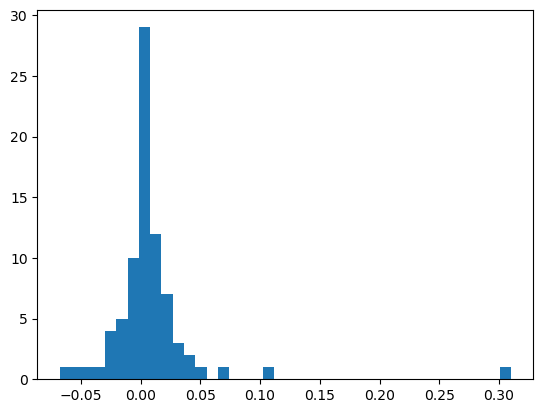

In [9]:
plt.figure()
plt.hist(equity_changes.values(), bins=40)
plt.show()

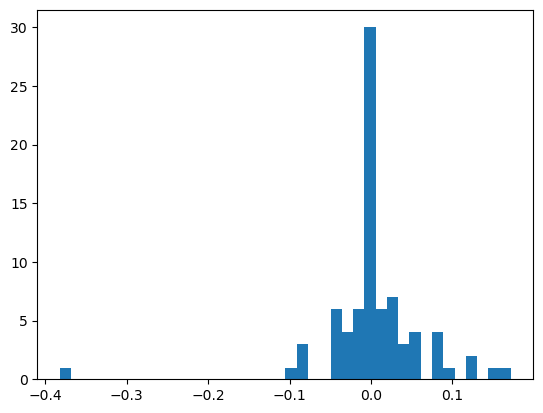

In [5]:
plt.figure()
plt.hist(equity_changes.values(), bins=40)
plt.show()